Brain tissue


Hướng dẫn sử dụng: Thêm hình ảnh não MRI vào src và run all 

Đọc hình ảnh

In [ ]:
pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 34.7 MB/s eta 0:00:00


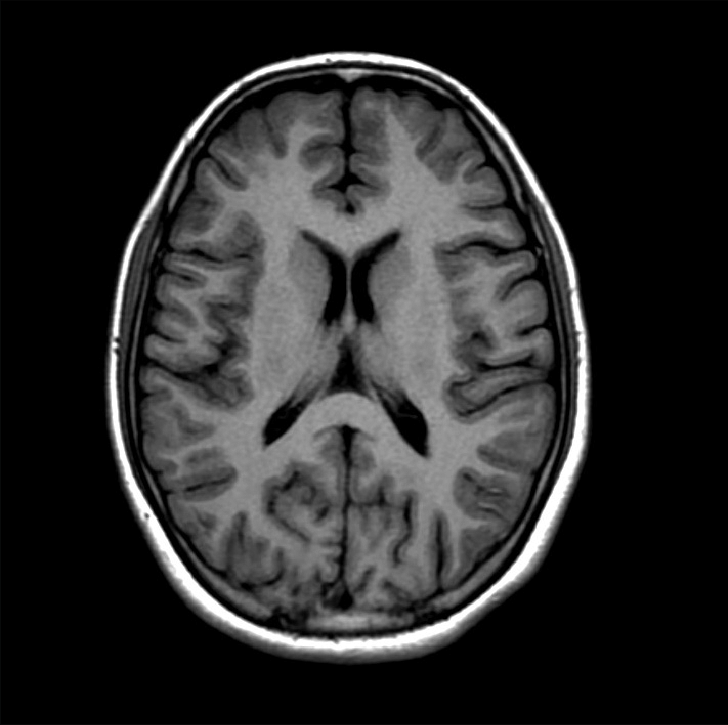

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DoAnThiGiacMayTinh/brain_tissueee.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)

In [ ]:
print(image.shape)
print(image_gray.shape)

(725, 728, 3)
(725, 728)


Trực quan

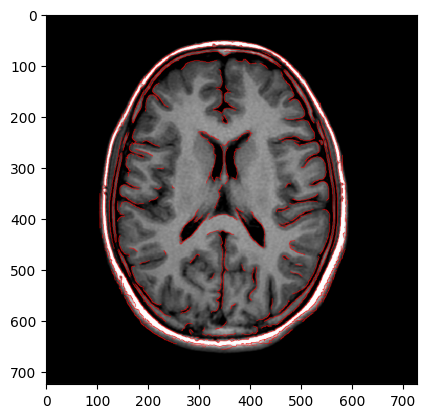

In [ ]:
edges = cv2.Canny(image, 100, 200)
canny = image.copy()

contours, hie = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(canny, contours, -1, (255, 0, 0), 1)

plt.imshow(canny)
plt.show()

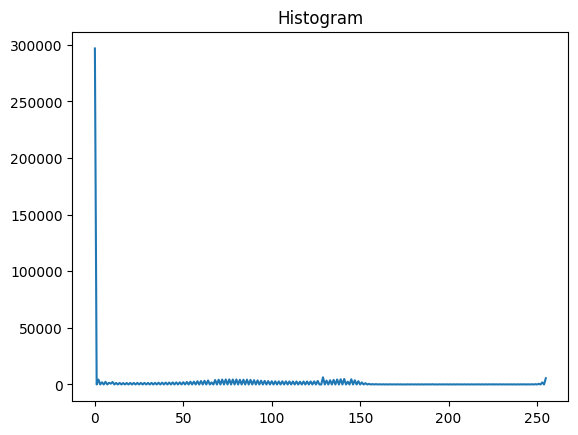

In [ ]:
hist = cv2.calcHist([image_gray], [0], None, [256], [0, 256])
plt.plot(hist)
plt.title('Histogram')
plt.show()

Xử lý hình ảnh

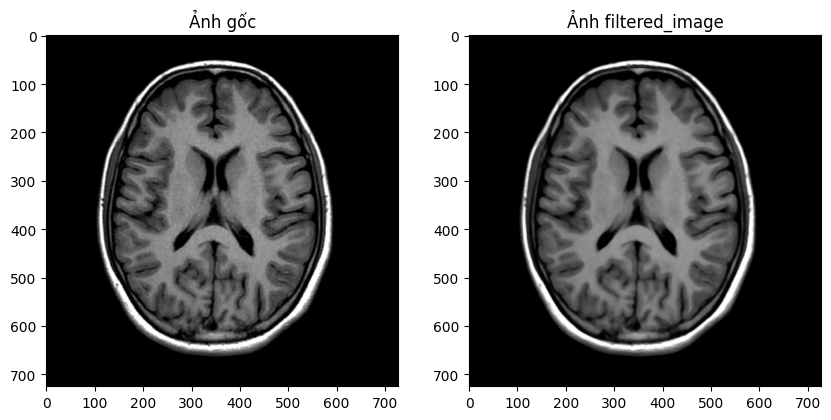

In [ ]:
filtered_image = cv2.medianBlur(image, 7)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Ảnh gốc')
plt.imshow(image, cmap='gray')

plt.subplot(122)
plt.title('Ảnh filtered_image')
plt.imshow(filtered_image, cmap='gray')


Fuzzy C-Means

In [ ]:
import numpy as np

def normalize_columns(columns): #chuẩn hóa ma trận, columns (M x N) M:hàng, N:cột
    normalized_columns = columns/np.sum(columns, axis=0, keepdims=1)

    return normalized_columns


def normalize_power_columns(x, exponent):
    assert np.all(x >= 0.0) # check all gtri của x >= 0

    x = x.astype(np.float64)

    x = x/np.max(x, axis=0, keepdims=True) #(item của x/max x) theo cột

    x = np.fmax(x, np.finfo(x.dtype).eps) #x > esp & eps là gtri nhỏ nhất của datatype(x) có thể biểu diễn, finfo trả về giới hạn của data type

    if exponent < 0:
        x /= np.min(x, axis=0, keepdims=True)

        x = x**exponent
    else:
        x = x**exponent

    result = normalize_columns(x) # kết quả (M x N) normalize_columns(x**n)

    return result

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

def _cmeans0(data, u_old, c, m, metric):
    u_old = normalize_columns(u_old) #đảm bảo mỗi cột của matrix có tổng = 1
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m

    data = data.T
    cntr = um.dot(data) / np.atleast_2d(um.sum(axis=1)).T

    d = _distance(data, cntr, metric)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = normalize_power_columns(d, - 2. / (m - 1))

    return cntr, u, jm, d


def _distance(data, centers, metric='euclidean'):
    return cdist(data, centers, metric=metric).T #các cột tương ứng với các cntr

def _fp_coeff(u):
    n = u.shape[1]
    return np.trace(u.dot(u.T)) / float(n) #tổng đường chéo chính (tương tự giữa mỗi cụm với chính nó)

def cmeans(data, c, m, error, maxiter,
           metric='euclidean',
           init=None, seed=None):
    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = data.shape[1]
        u0 = np.random.rand(c, n)
        u0 = normalize_columns(u0)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps) #>= esp

    jm = np.zeros(0)
    p = 0

    while p < maxiter - 1:
        u2 = u.copy()
        [cntr, u, Jjm, d] = _cmeans0(data, u2, c, m, metric)
        jm = np.hstack((jm, Jjm)) #nối Jjm vào cuối mảng jm
        p += 1

        if np.linalg.norm(u - u2) < error: #???
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return cntr, u, u0, d, jm, p, fpc



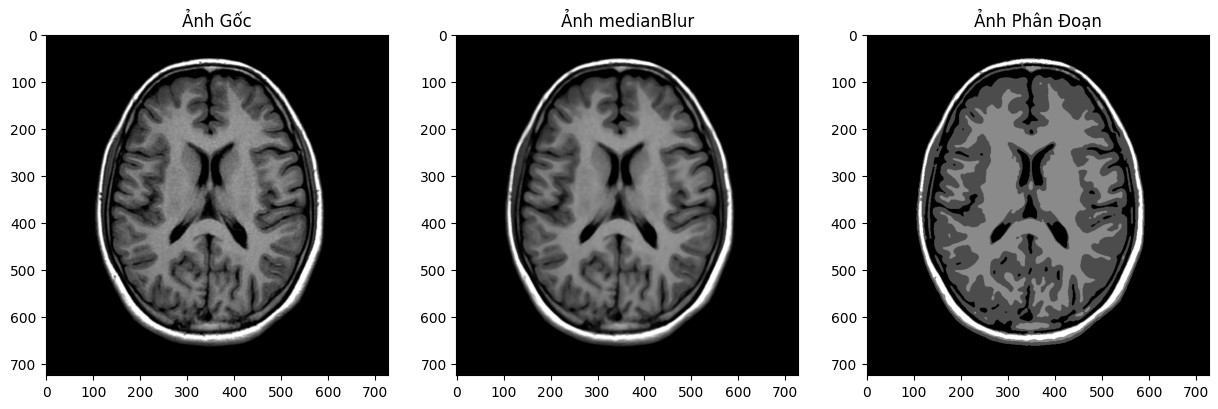

[[1.09268585e-03 4.06961268e-04 4.06961268e-04 ... 1.39547927e-03
  1.39547927e-03 1.39547927e-03]
 [3.96661798e-03 1.44390588e-03 1.44390588e-03 ... 5.10557479e-03
  5.10557479e-03 5.10557479e-03]
 [1.42347133e-02 4.96662837e-03 4.96662837e-03 ... 1.85952440e-02
  1.85952440e-02 1.85952440e-02]
 [9.80705983e-01 9.93182504e-01 9.93182504e-01 ... 9.74903702e-01
  9.74903702e-01 9.74903702e-01]]
[6.01861590e+08 4.58633569e+08 4.58508576e+08 4.56621536e+08
 4.34252102e+08 3.16743525e+08 1.79761156e+08 1.26175635e+08
 1.01054756e+08 9.28976926e+07 8.99684332e+07 8.84423680e+07
 8.74174197e+07 8.66355072e+07 8.60010971e+07 8.54691282e+07
 8.50132715e+07 8.46153954e+07 8.42615314e+07 8.39399973e+07
 8.36402148e+07 8.33516242e+07 8.30622698e+07 8.27563902e+07
 8.24094499e+07 8.19761890e+07 8.13571437e+07 8.02879767e+07
 7.79168896e+07 7.14459640e+07 5.84023897e+07 4.94585475e+07
 4.76384454e+07 4.73810225e+07 4.73245148e+07 4.73071109e+07
 4.73012142e+07 4.72991792e+07 4.72984751e+07 4.729823

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DoAnThiGiacMayTinh/anhT1W_512.png')

# cv2_imshow(image)
# cv2_imshow(filtered_image)

# image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
data = filtered_image_gray.reshape((-1, 1))
filtered_image.shape
n_clusters = 4

cntr, u, u0, d, jm, p, fpc = cmeans(data.T, n_clusters, 2, error=0.005, maxiter=100) #fpc m = 1.1 fpc = 0.9

cluster_membership = np.argmax(u, axis=0) #tìm cụm cho từng pixel (xét theo cột tìm giá trị lớn nhất trong ma trận u trên từng cụm để gán cụm cho từng pixel) kết quả: một mảng chứa chỉ số của cụm mà từng pixel thuộc về.

cluster_colors = cntr # shape = (4,5)
segmented_image = cluster_colors[cluster_membership].reshape(filtered_image_gray.shape) # (5,4)[4200000,] -> (2100,2000,4) {5 cụm, 4 kênh màu}
# cv2_imshow(segmented_image)
segmented_image.astype(np.uint8)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Ảnh Gốc')

plt.subplot(1, 3, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Ảnh medianBlur')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image.astype(np.uint8), cmap='gray')
plt.title('Ảnh Phân Đoạn')

plt.show()
print(u)
print(jm)
print(p)
print(fpc)
print(cntr)

In [ ]:
filtered_image.shape

(725, 728, 3)

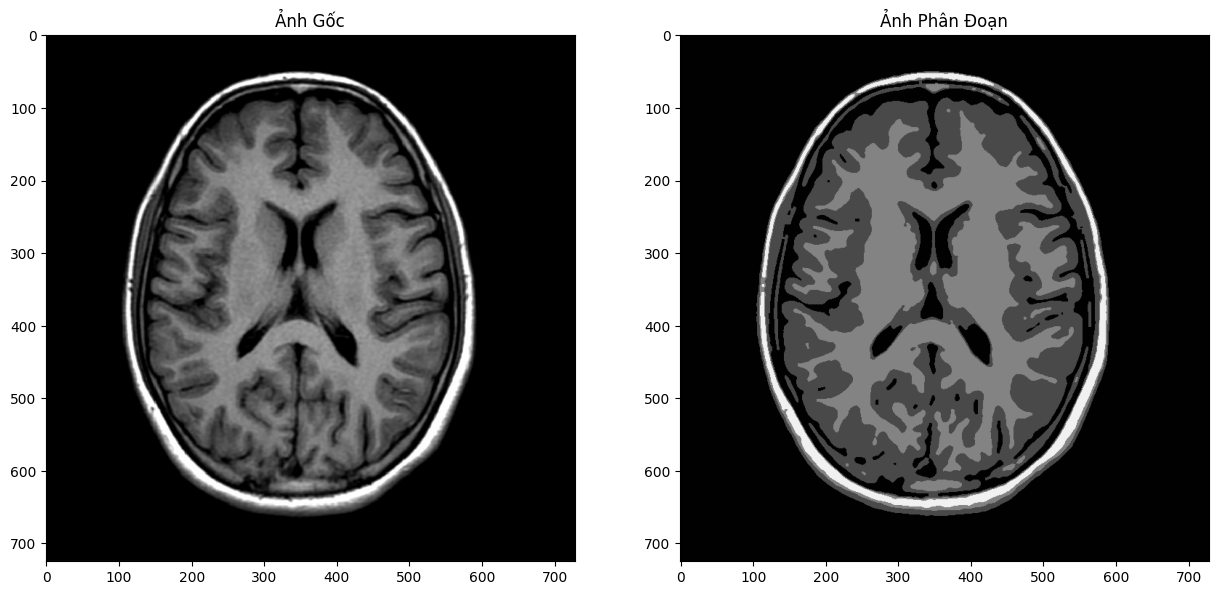

[1.80479783e+09 1.37587606e+09 1.37530634e+09 1.36681072e+09
 1.26615157e+09 7.94128467e+08 4.56038691e+08 3.27087334e+08
 2.77299843e+08 2.66713745e+08 2.62796111e+08 2.60269655e+08
 2.58294250e+08 2.56653977e+08 2.55254337e+08 2.54036514e+08
 2.52956787e+08 2.51979227e+08 2.51071783e+08 2.50203012e+08
 2.49338082e+08 2.48432215e+08 2.47417522e+08 2.46172081e+08
 2.44435426e+08 2.41536492e+08 2.35371302e+08 2.18816136e+08
 1.81713443e+08 1.50655347e+08 1.43239294e+08 1.42210136e+08
 1.42001516e+08 1.41939298e+08 1.41918364e+08 1.41911148e+08
 1.41908652e+08 1.41907788e+08 1.41907489e+08 1.41907386e+08
 1.41907351e+08 1.41907338e+08 1.41907334e+08 1.41907332e+08
 1.41907332e+08 1.41907332e+08]
46
0.9130975411309417
[[ 73.55097207  73.55097207  73.55096756]
 [131.28314218 131.28314218 131.28314178]
 [  1.22523489   1.22523489   1.2208452 ]
 [241.98562846 241.98562846 241.98562826]]


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

image_gray = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
data = filtered_image.reshape((-1, 3))
data.shape
n_clusters = 4

cntr, u, u0, d, jm, p, fpc = cmeans(data.T, n_clusters, 2, error=0.005, maxiter=100) #fpc m = 1.1 fpc = 0.9

cluster_membership = np.argmax(u, axis=0) #tìm cụm cho từng pixel (xét theo cột tìm giá trị lớn nhất trong ma trận u trên từng cụm để gán cụm cho từng pixel) kết quả: một mảng chứa chỉ số của cụm mà từng pixel thuộc về.

cluster_colors = cntr # shape = (4,5)
segmented_image_graycolor = cluster_colors[cluster_membership].reshape(filtered_image.shape) # (5,4)[4200000,] -> (2100,2000,4) {5 cụm, 4 kênh màu}

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Ảnh Gốc')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_graycolor.astype(np.uint8))
plt.title('Ảnh Phân Đoạn')

plt.show()
print(jm)
print(p)
print(fpc)
print(cntr)

In [ ]:
colors = np.array([[250,0,0],
          [0,250,0],
          [0,0,250],
          [250,0,250]
                   ])
for i in range(len(cluster_colors)):
  for j in range(len(colors[i])):
    cluster_colors[i][j] = colors[i][j]

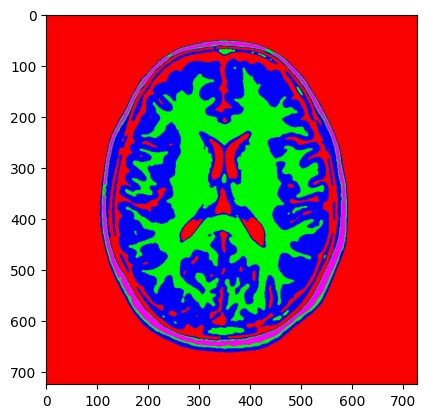

In [ ]:
segmented_image = cluster_colors[cluster_membership].reshape(filtered_image.shape) # (4,3)[4200000,] -> (2100,2000,3) {4 cụm, 3 kênh màu}
segmented_image_u8 = segmented_image.astype(np.uint8)
segmented_image_new = cv2.cvtColor(segmented_image_u8, cv2.COLOR_BGR2RGB)
plt.imshow(segmented_image_new.astype(np.uint8))


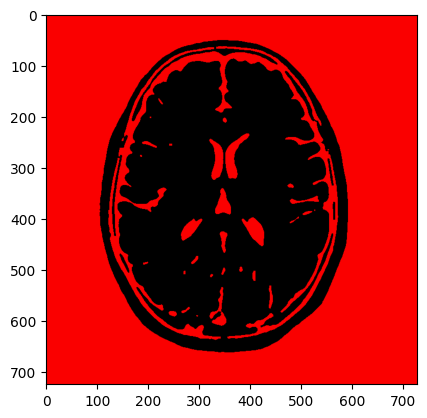

In [ ]:
lower_threshold1 = np.array([240, 0, 0])
upper_threshold1 = np.array([255, 0, 0])

# Áp dụng ngưỡng để tách các pixel dựa trên màu sắc
mask1 = cv2.inRange(segmented_image_new, lower_threshold1, upper_threshold1)
result1 = cv2.bitwise_and(segmented_image_new, segmented_image_new, mask=mask1)

plt.imshow(result1)

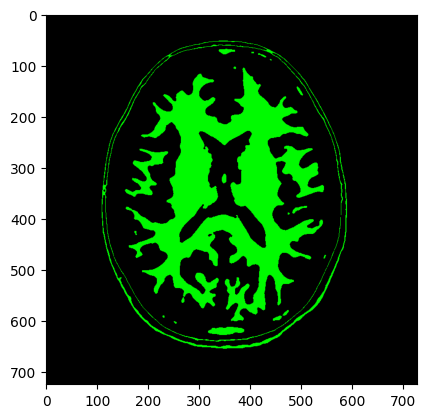

In [ ]:
lower_threshold2 = np.array([0, 240, 0])
upper_threshold2 = np.array([0, 255, 0])

# Áp dụng ngưỡng để tách các pixel dựa trên màu sắc
mask2 = cv2.inRange(segmented_image_new, lower_threshold2, upper_threshold2)
result2 = cv2.bitwise_and(segmented_image_new, segmented_image_new, mask=mask2)

plt.imshow(result2)

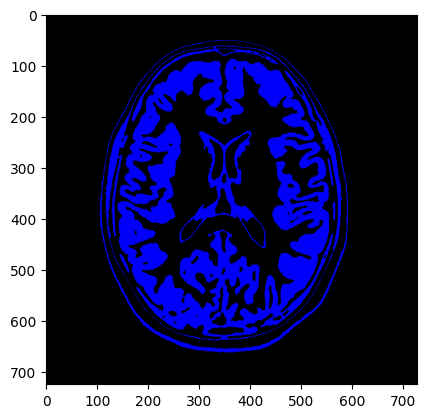

In [ ]:
lower_threshold3 = np.array([0, 0, 240])
upper_threshold3 = np.array([0, 0, 255])

# Áp dụng ngưỡng để tách các pixel dựa trên màu sắc
mask3 = cv2.inRange(segmented_image_new, lower_threshold3, upper_threshold3)
result3 = cv2.bitwise_and(segmented_image_new, segmented_image_new, mask=mask3)

plt.imshow(result3)

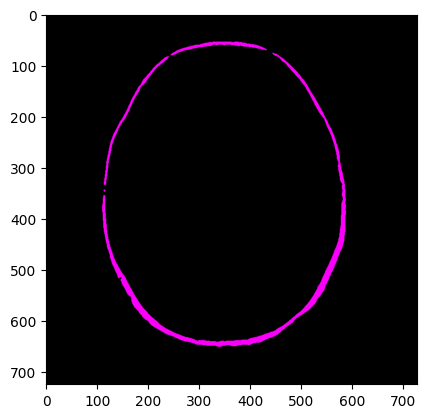

In [ ]:
lower_threshold4 = np.array([240, 0, 240])
upper_threshold4 = np.array([255, 0, 255])

# Áp dụng ngưỡng để tách các pixel dựa trên màu sắc
mask4 = cv2.inRange(segmented_image_new, lower_threshold4, upper_threshold4)
result4 = cv2.bitwise_and(segmented_image_new, segmented_image_new, mask=mask4)

plt.imshow(result4)

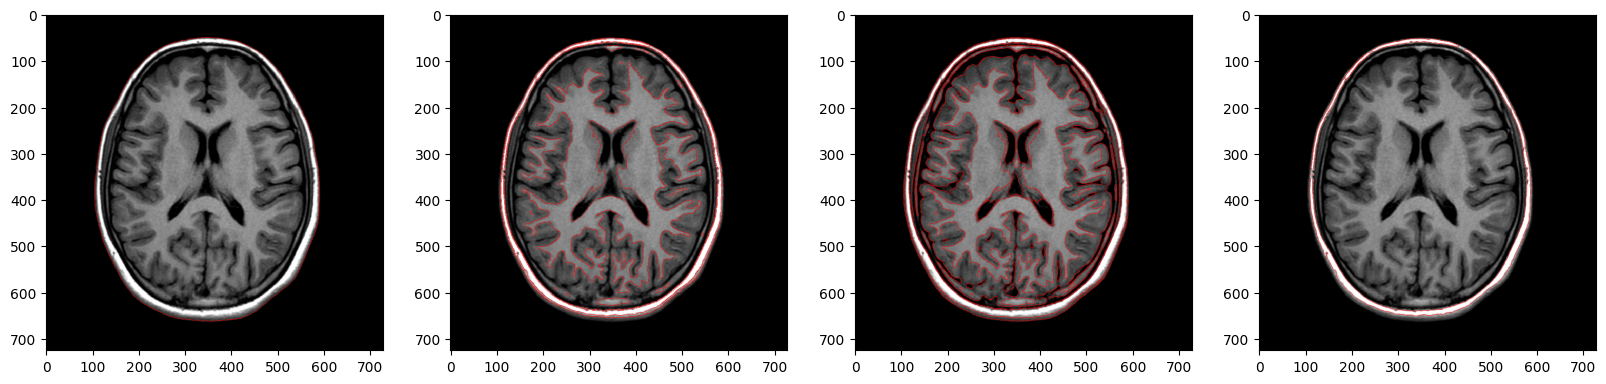

In [ ]:
result1 = cv2.convertScaleAbs(result1)
result2 = cv2.convertScaleAbs(result2)
result3 = cv2.convertScaleAbs(result3)
result4 = cv2.convertScaleAbs(result4)

edges1 = cv2.Canny(result1, 100, 200)
edges2 = cv2.Canny(result2, 100, 200)
edges3 = cv2.Canny(result3, 100, 200)
edges4 = cv2.Canny(result4, 100, 200)

ori_canny1 = image.copy()
ori_canny2 = image.copy()
ori_canny3 = image.copy()
ori_canny4 = image.copy()

contours1, hie1 = cv2.findContours(edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(ori_canny1, contours1, -1, (255, 0, 0), 1)

contours2, hie2 = cv2.findContours(edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(ori_canny2, contours2, -1, (255, 0, 0), 1)

contours3, hie3 = cv2.findContours(edges3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(ori_canny3, contours3, -1, (255, 0, 0), 1)

contours4, hie4 = cv2.findContours(edges4, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(ori_canny4, contours4, -1, (255, 0, 0), 1)

plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(ori_canny1)

plt.subplot(142)
plt.imshow(ori_canny2)

plt.subplot(143)
plt.imshow(ori_canny3)

plt.subplot(144)
plt.imshow(ori_canny4)

plt.show()

Đánh giá

FPC của cụm thứ 2: 0.9166012364698601
FPC của cụm thứ 3: 0.9067153648754235
FPC của cụm thứ 4: 0.915050873358707
FPC của cụm thứ 5: 0.8992544695641069
FPC của cụm thứ 6: 0.8922818714071163
FPC của cụm thứ 7: 0.8832761613400654
FPC của cụm thứ 8: 0.8798591742221871


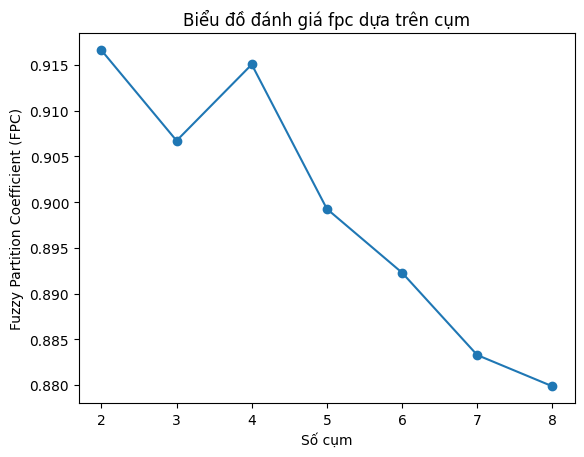

In [ ]:
n_clusters_range = range(2, 9)
fpc_values = []

for n_clusters in n_clusters_range:
    cntr, u, u0, d, jm, p, fpc = cmeans(data.T, n_clusters, 2, error=0.005, maxiter=100)
    fpc_values.append(fpc)
    print(f'FPC của cụm thứ {n_clusters}: {fpc}')

plt.plot(n_clusters_range, fpc_values, marker='o')
plt.xlabel('Số cụm')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.title('Biểu đồ đánh giá fpc dựa trên cụm')
plt.show()


So sánh tương đồng giữa ảnh gốc và ảnh sau khi phân đoạn

In [ ]:
from sklearn.metrics import mean_squared_error

image = image.astype(np.uint8)
segmented_image_new = segmented_image_new.astype(np.uint8)

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
segmented_image_new_gray = cv2.cvtColor(segmented_image_new, cv2.COLOR_BGR2GRAY)
print(segmented_image_new.shape)

mse = mean_squared_error(image_gray, segmented_image_new_gray)
print("Mean Squared Error (MSE) giữa hai hình ảnh là:", mse)


(725, 728, 3)
Mean Squared Error (MSE) giữa hai hình ảnh là: 48.61273020083366
